# Preprocessing, GridSearch and Training F-DenseNet-6 and F-DenseNet-8 on Open Data
# Part 1/3

In [1]:
import numpy as np
from numpy import array
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import math

import matplotlib.pylab as plt
from matplotlib.pyplot import cm
import seaborn as sns
import itertools
import collections
from collections import OrderedDict, Counter

import scipy.stats as stats
from scipy.stats import normaltest, kstest, ttest_ind, ttest_rel, mannwhitneyu, wilcoxon, levene, bartlett
from scipy.stats import chi2_contingency, fisher_exact, mode, pearsonr, f_oneway, kruskal, spearmanr

from rfpimp import *

from datetime import datetime
import re
from seaborn import heatmap
import random
import statsmodels.distributions.empirical_distribution as edf
from scipy.interpolate import interp1d
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.utils import resample
from functools import reduce
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

from sklearn import metrics, preprocessing
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, log_loss, recall_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PowerTransformer

from sklearn.utils import check_consistent_length, column_or_1d, assert_all_finite
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.multiclass import type_of_target
from sklearn.linear_model import LogisticRegression
import re
import gc

import os

#from sklearn.externals import joblib
import joblib

from importlib import reload
import Filter_and_Grid_Search
Filter_and_Grid_Search = reload(Filter_and_Grid_Search)
from Filter_and_Grid_Search import stratified_split
from Filter_and_Grid_Search import attributes_list, attributes_list_new
from Filter_and_Grid_Search import get_s_stat, get_PSI_stat, get_stats_by_month, get_stats, stable_unstable
from Filter_and_Grid_Search import stable_unstable_by_month_divide, union_datas, individual_hists_all 
from Filter_and_Grid_Search import paired_time_hists_by_month, statistics_with_target
from Filter_and_Grid_Search import receive_correlations, find_doubles_corr
from Filter_and_Grid_Search import statistics_with_target, attributes_list, attributes_list_new, make_standard
from Filter_and_Grid_Search import data_preprocessing_train, data_preprocessing_test
from Filter_and_Grid_Search import receive_correlations, find_doubles_corr
from Filter_and_Grid_Search import stratified_split, two_forests, turn_variables_with_values
from Filter_and_Grid_Search import find_meta_params, calculate_vif#, find_meta_params_mem
from Filter_and_Grid_Search import plot_meta_2d, data_preprocessing, find_ouliers_iqr
from Filter_and_Grid_Search import train_model_receive_stats, simple_b_score_risk
from Filter_and_Grid_Search import max_prof_corve, by_month_gini, check_attribute_list_cases

from Filter_and_Grid_Search import to_zip, br_correction, br_stat

from statsmodels.stats.proportion import proportions_ztest

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pathlib
import psutil

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
PATH_DATA = 'D:/Share/01 -Risk Desc Science/AntiFraud/Chinese_data/Datasets/'
PATH = 'D:/Share/safanasev/Python-notebook/AF_ML_chinese/'
print(PATH_DATA)
print(PATH)

D:/Share/01 -Risk Desc Science/AntiFraud/Chinese_data/Datasets/
D:/Share/safanasev/Python-notebook/AF_ML_chinese/


In [3]:
task = 'binary'
missing_strings = 'MISSING'
p_value = 0.05
target_dict = {'good': 0, 'bad': 1}

In [4]:
target = 'LABEL'
index_month = 'MONTH'
list_of_vars_for_strat = ['MONTH']
sort_by_var = 'ID'

necessary_fields = [target, index_month, sort_by_var]

COL_DEL = ['Unnamed: 0'] 
COL_DEL = [x.upper() for x in COL_DEL]
COL_TRG = target

In [10]:
PATH + 'train_128_prep.csv'

'D:/Share/asmirnova5/Python-notebook/AF_ML_chinese/train_128_prep.csv'

## Loading preprocessed data

In [11]:
PATH = 'D:/Share/safanasev/Python-notebook/AF_ML_chinese/'
train_for = pd.read_csv(PATH + 'china_train_128_prep.csv')
valid_for = pd.read_csv(PATH + 'china_val_128_prep.csv')
test_for = pd.read_csv(PATH + 'china_test_128_prep.csv')

In [12]:
y_train = train_for[target]
y_val = valid_for[target]
y_test = test_for[target]

train_for.drop('Unnamed: 0', axis = 1, inplace = True)
valid_for.drop('Unnamed: 0', axis = 1, inplace = True)
test_for.drop('Unnamed: 0', axis = 1, inplace = True)


col = train_for.columns.to_list()
col.remove(target)


X_1_2 = train_for[col]
X_2_2 = valid_for[col]
X_3_2 = test_for[col]

In [13]:
X_2_2.columns

Index(['F1', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       ...
       'F275', 'F276', 'F277', 'F283', 'F288', 'F296', 'F5_bin', 'F36_bin',
       'F48_bin', 'F166_bin'],
      dtype='object', length=128)

In [14]:
x_col = X_2_2.columns
y_col = 'LABEL'

In [15]:
from keras.utils import np_utils

In [16]:
Y_test_2 = np_utils.to_categorical( y_val, 2) # преобразовываем в 2 класса 

In [17]:
len(x_col)

128

In [18]:
train_for.shape

(792004, 129)

## Tensorflow

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Activation, Dense, Flatten, Dropout)
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, AveragePooling1D)
from tensorflow.keras.layers import add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from keras.utils import np_utils

In [20]:
from tensorflow.keras.layers import ReLU, Concatenate, GlobalAveragePooling1D

In [21]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 29

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)


# 5. Configure a new global `tensorflow` session
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [22]:
#если alpha не задано, то не делаем br_correction

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,  dataset, x_col, y_col,  batch_size=256, num_classes=2, alpha = 0.1, random_state = 42, 
                 shuffle=True, class_w = None):
        self.batch_size = batch_size
        self.dataset = dataset
        self.x_col = x_col
        self.y_col = y_col
        self.indices = self.dataset.index.tolist()
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.alpha = alpha
        self.random_state = random_state
        self.class_w = class_w
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.indices) / self.batch_size)

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        data_tmp = self.dataset.loc[batch]
        data_tmp_b = data_tmp[data_tmp[self.y_col] == 1]
        data_tmp_b_all = self.dataset[self.dataset[self.y_col] == 1]
        X_tmp = data_tmp.head(0)
        
        
        #print(data_tmp_b.shape[0], data_tmp.shape[0], data_tmp_b_all.shape[0])
        if (self.alpha is None) and (self.class_w is None):
            X = data_tmp[self.x_col] #.reshape(-1)
            y = data_tmp[self.y_col] 
            
        elif (self.alpha is None) and self.class_w > 0:
            k = (self.class_w*self.batch_size)/(1-self.class_w)
            k = k - data_tmp_b.shape[0]
            if int(k) < 1:
                k = k+1
            ix2 = np.random.RandomState(self.random_state + int(k)).choice(data_tmp_b_all.shape[0], int(k))
            X_tmp = data_tmp_b_all.iloc[ix2]
            data_tmp = data_tmp.append(X_tmp, ignore_index=True)
            X = data_tmp[self.x_col] #.reshape(-1)
            y = data_tmp[self.y_col]
            #print(data_tmp_b.shape[0], data_tmp.shape[0],  data_tmp_b.shape[0]/(data_tmp.shape[0] - X_tmp.shape[0]), np.mean(y)) 
            
            
            
        else:
            if data_tmp_b.shape[0] > 0:
                k=(self.alpha*self.batch_size/data_tmp_b.shape[0] -1 )/(1-self.alpha)
                for i in range(0,int(k)):
                    X_tmp = X_tmp.append(data_tmp_b, ignore_index=True)
            else:
                k = (self.alpha*self.batch_size)/(1-self.alpha)
                ix2 = np.random.RandomState(self.random_state + int(k)).choice(data_tmp_b_all.shape[0], int(k))
                X_tmp = data_tmp_b_all.iloc[ix2]
                data_tmp_b = X_tmp

    #         print('Добавим дробное число строк')    
            k_fraction = k - int(k)
            n_samples = int(round(data_tmp_b.shape[0]*k_fraction))
    #         print(k_fraction, n_samples)

            ix = np.random.RandomState(self.random_state).choice(data_tmp_b.shape[0], n_samples)
            data_add_fraction = data_tmp_b.iloc[ix]
            X_tmp.append(data_add_fraction, ignore_index=True)

            data_tmp = data_tmp.append(X_tmp, ignore_index=True)


            X = data_tmp[self.x_col] #.reshape(-1)
            y = data_tmp[self.y_col]   
        #print(sum(self.dataset.loc[batch][self.y_col])/len(index), np.mean(y))
        
        if self.num_classes > 1:
            y = np_utils.to_categorical( y, self.num_classes)
            
        ####for tf 2.3.0, [np.array(X)], np.array(y)

        #return [np.array(X).reshape(X.shape[0], X.shape[1], 1)], np.array(y)
        return [np.array(X)], np.array(y)

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, Callback

# объявляем класс метрик

class E_time(Callback):
    def on_train_begin(self, logs={}):
        tm = datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S")
        print ('train_begin', '| time: ' , tm)
        
    def on_epoch_end(self, epoch, logs={}):
        tm = datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S")
        print ('epoch_end', '| time: ' , tm)
    
        return

_time = E_time()

In [24]:
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = self.model.predict(self.validation_data[0])[:, 1]
        val_targ = self.validation_data[1]
        
        if len(val_targ.shape) == 2: #and val_targ.shape[1] != 1:
            val_targ = val_targ[:,1]

        _val_aps = metrics.average_precision_score(val_targ, val_predict)
        #_val_recall = metrics.recall_score(val_targ, val_predict)
        _val_a = metrics.roc_auc_score(val_targ, val_predict)

        logs['val_aps'] = _val_aps
        logs['val_a'] = _val_a
        print(" — val_aps:  %f — val_a: %f" % (_val_aps, _val_a))
        return

In [25]:
def max_pool(min_pool, n_pool, padding_pool,  str_pool, y, str_min = 1):
    #for 3D-tensor
    if y.shape[1] < (min_pool):
        
        return MaxPooling1D(pool_size = n_pool, padding=padding_pool, strides=str_min)(y)
    else:
        return MaxPooling1D(pool_size = n_pool, padding=padding_pool, strides=str_pool)(y)

## F-DenseNet-6 (with poolings after each convolution)¶

In [26]:
def fraud_dense_model_6_pool(l2_conv = None, reg = 1E-5 , reg_dense = 1E-5,
                 _bias = True,  n_features = 163, n_pool = 2, n_kernel = 5, n_filters = 5, n_strides = 1,
                 classes = 2, hidden = 64 , drop_out = 0.25, drop_out_conv = 0.001, drop_out_rate = 4 ,
                 padding_pool = 'valid' ,
                gl_pool_max = False):
    
    if reg == None:
        l2_batch_gamma = None 
        l2_batch_betta = None
    else:
        l2_batch_gamma = l2(reg)
        l2_batch_betta =l2(reg)
    
    if reg_dense == None:
        kernel_regularizer = None
    else:
        kernel_regularizer = l2(reg)   
    
    
    x = Input(shape=(  n_features, 1))
    n = 0
    y = Conv1D(filters=n_filters, kernel_size=n_kernel, strides=n_strides, padding='same', 
           use_bias=_bias, kernel_regularizer=l2_conv)(x) 

    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
#y = Dropout(rate=drop_rate)(y)

    y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##
    shortcut1_2 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y)## поправить


    # второй conv-block
    y = Conv1D(filters=n_filters*2, kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##


    y= Concatenate(axis=-1)([shortcut1_2, y])
    n = n+1

    # третий conv-block
    y = Conv1D(filters=n_filters*(3 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##
    n = n+1
    
    # четвертый conv-block
    y = Conv1D(filters=n_filters*(4 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##
    shortcut4_6 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y)##

    # пятый conv-block
    y = Conv1D(filters=n_filters*(5 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##
    y= Concatenate(axis=-1)([shortcut4_6,  y])

    # шестой conv-block
    y = Conv1D(filters=n_filters*(6 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
    if gl_pool_max:
        z = GlobalMaxPooling1D()(y)
        
    else:
        z = GlobalAveragePooling1D()(y)
    #z = Flatten()(y) #сглаживание, пример использования - https://stackoverflow.com/questions/43237124/what-is-the-role-of-flatten-in-keras
    z = Dense(hidden, activation='relu', kernel_regularizer = kernel_regularizer)(z)
    z = Dropout(drop_out)(z)
    z = Dense(hidden, activation='relu', kernel_regularizer = kernel_regularizer)(z)
    z = Dropout(drop_out)(z)
    predictions = Dense(classes, activation='softmax')(z)

    #model = Sequential()
    model_15 = Model(inputs=x, outputs=predictions)
    
    return model_15

In [27]:
def max_pool(min_pool, n_pool, padding_pool, str_pool, y ):
    if y.shape[1] < (min_pool):
        
        return MaxPooling1D(pool_size = n_pool, padding=padding_pool, strides=1)(y)
    else:
        return MaxPooling1D(pool_size = n_pool, padding=padding_pool, strides=str_pool)(y)

## F-DenseNet-8 (with poolings after each convolution)¶

In [44]:
def fraud_dense_model_8_pool(l2_conv = None, reg = 1E-5 , reg_dense = 1E-5,
                 _bias = True,  n_features = 163, n_pool = 2, n_kernel = 5, n_filters = 5, n_strides = 1,
                 classes = 2, hidden = 64 , drop_out = 0.25, drop_out_conv = 0.001, drop_out_rate = 4 ,
                 padding_pool = 'valid' ,
                gl_pool_max = False, min_pool = 15, str_pool = None):
    
    if reg == None:
        l2_batch_gamma = None 
        l2_batch_betta = None
    else:
        l2_batch_gamma = l2(reg)
        l2_batch_betta =l2(reg)
    
    if reg_dense == None:
        kernel_regularizer = None
    else:
        kernel_regularizer = l2(reg)   
    
    
    x = Input(shape=(  n_features, 1))
    n = 0
    y = Conv1D(filters=n_filters, kernel_size=n_kernel, strides=n_strides, padding='same', 
           use_bias=_bias, kernel_regularizer=l2_conv)(x) 

    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
#y = Dropout(rate=drop_rate)(y)

    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y) ##
    shortcut1_2 = max_pool(min_pool, n_pool, padding_pool, str_pool, y)
    shortcut1_3 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut1_2)

    # второй conv-block
    y = Conv1D(filters=n_filters*2, kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y)
    shortcut2_3 = max_pool(min_pool, n_pool, padding_pool, str_pool, y)
    y= Concatenate(axis=-1)([shortcut1_2, y])

    # третий conv-block
    y = Conv1D(filters=n_filters*(3 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y)
    y= Concatenate(axis=-1)([shortcut2_3, shortcut1_3, y])

    
    # четвертый conv-block
    y = Conv1D(filters=n_filters*(4 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y) ##


    # пятый conv-block
    y = Conv1D(filters=n_filters*(5 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y)
    shortcut5_7 = max_pool(min_pool, n_pool, padding_pool, str_pool, y)
    shortcut5_8 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut5_7)

    # шестой conv-block
    y = Conv1D(filters=n_filters*(6 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
    
    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y)
    shortcut6_8 = max_pool(min_pool, n_pool, padding_pool, str_pool, y)
    
    y= Concatenate(axis=-1)([shortcut5_7, y])
    
    # седьмой conv-block
    y = Conv1D(filters=n_filters*(7 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
    
    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y)
    y= Concatenate(axis=-1)([shortcut6_8, shortcut5_8, y])
    
    # восьмой conv-block
    y = Conv1D(filters=n_filters*(8 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y)
    
    
    if gl_pool_max:
        z = GlobalMaxPooling1D()(y)
        
    else:
        z = GlobalAveragePooling1D()(y)
    #z = Flatten()(y) #сглаживание, пример использования - https://stackoverflow.com/questions/43237124/what-is-the-role-of-flatten-in-keras
    z = Dense(hidden, activation='relu', kernel_regularizer = kernel_regularizer)(z)
    z = Dropout(drop_out)(z)
    z = Dense(hidden, activation='relu', kernel_regularizer = kernel_regularizer)(z)
    z = Dropout(drop_out)(z)
    predictions = Dense(classes, activation='softmax')(z)

    #model = Sequential()
    model_15 = Model(inputs=x, outputs=predictions)
    
    return model_15

## F-DenseNet-6_pure

In [29]:
def fraud_dense_model_6_pure(l2_conv = None, reg = 1E-5 , reg_dense = 1E-5,
                 _bias = True,  n_features = 163, n_pool = 2, n_kernel = 5, n_filters = 5, n_strides = 1,
                 classes = 2, hidden = 64 , drop_out = 0.25, drop_out_conv = 0.001, drop_out_rate = 4 ,
                 padding_pool = 'valid' ,
                gl_pool_max = False):
    
    if reg == None:
        l2_batch_gamma = None 
        l2_batch_betta = None
    else:
        l2_batch_gamma = l2(reg)
        l2_batch_betta =l2(reg)
    
    if reg_dense == None:
        kernel_regularizer = None
    else:
        kernel_regularizer = l2(reg)   
    
    
    x = Input(shape=(  n_features, 1))
    n = 0
    y = Conv1D(filters=n_filters, kernel_size=n_kernel, strides=n_strides, padding='same', 
           use_bias=_bias, kernel_regularizer=l2_conv)(x) 

    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
#y = Dropout(rate=drop_rate)(y)

    shortcut1_2 = y


    # второй conv-block
    y = Conv1D(filters=n_filters*2, kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y= Concatenate(axis=-1)([shortcut1_2, y])
    n = n+1

    # третий conv-block
    y = Conv1D(filters=n_filters*(3 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##
    
    # четвертый conv-block
    y = Conv1D(filters=n_filters*(4 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    shortcut4_6 =y

    # пятый conv-block
    y = Conv1D(filters=n_filters*(5 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y= Concatenate(axis=-1)([shortcut4_6,  y])

    # шестой conv-block
    y = Conv1D(filters=n_filters*(6 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
    
    if gl_pool_max:
        z = GlobalMaxPooling1D()(y)
        
    else:
        z = GlobalAveragePooling1D()(y)
    #z = Flatten()(y) #сглаживание, пример использования - https://stackoverflow.com/questions/43237124/what-is-the-role-of-flatten-in-keras
    z = Dense(hidden, activation='relu', kernel_regularizer = kernel_regularizer)(z)
    z = Dropout(drop_out)(z)
    z = Dense(hidden, activation='relu', kernel_regularizer = kernel_regularizer)(z)
    z = Dropout(drop_out)(z)
    predictions = Dense(classes, activation='softmax')(z)

    #model = Sequential()
    model_15 = Model(inputs=x, outputs=predictions)
    
    return model_15

## F-DenseNet-8_pure

In [30]:
def fraud_dense_model_8_pure(l2_conv = None, reg = 1E-5 , reg_dense = 1E-5,
                 _bias = True,  n_features = 163, n_pool = 2, n_kernel = 5, n_filters = 5, n_strides = 1,
                 classes = 2, hidden = 64 , drop_out = 0.25, drop_out_conv = 0.001, drop_out_rate = 4 ,
                 padding_pool = 'valid' ,
                gl_pool_max = False):
    
    if reg == None:
        l2_batch_gamma = None 
        l2_batch_betta = None
    else:
        l2_batch_gamma = l2(reg)
        l2_batch_betta =l2(reg)
    
    if reg_dense == None:
        kernel_regularizer = None
    else:
        kernel_regularizer = l2(reg)   
    
    
    x = Input(shape=(  n_features, 1))
    n = 0
    y = Conv1D(filters=n_filters, kernel_size=n_kernel, strides=n_strides, padding='same', 
           use_bias=_bias, kernel_regularizer=l2_conv)(x) 

    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
#y = Dropout(rate=drop_rate)(y)

    shortcut1_ = y
 

    # второй conv-block
    y = Conv1D(filters=n_filters*2, kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
    
    shortcut2_ = y
    y= Concatenate(axis=-1)([shortcut1_, y])
    

    # третий conv-block
    y = Conv1D(filters=n_filters*(3 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y= Concatenate(axis=-1)([shortcut2_, shortcut1_, y])
    
    # четвертый conv-block
    y = Conv1D(filters=n_filters*(4 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
    
    y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##один пулинг между блоками


    # пятый conv-block
    y = Conv1D(filters=n_filters*(5 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
    
    shortcut5_ =y


    # шестой conv-block
    y = Conv1D(filters=n_filters*(6 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
    
    shortcut6_ =y
    
    y= Concatenate(axis=-1)([ shortcut5_, y])

    
    # седьмой conv-block
    y = Conv1D(filters=n_filters*(7 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
    
    y= Concatenate(axis=-1)([shortcut6_, shortcut5_, y])
    
    
    # восьмой conv-block
    y = Conv1D(filters=n_filters*(8 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
    
    
    if gl_pool_max:
        z = GlobalMaxPooling1D()(y)
        
    else:
        z = GlobalAveragePooling1D()(y)
    #z = Flatten()(y) #сглаживание, пример использования - https://stackoverflow.com/questions/43237124/what-is-the-role-of-flatten-in-keras
    z = Dense(hidden, activation='relu', kernel_regularizer = kernel_regularizer)(z)
    z = Dropout(drop_out)(z)
    z = Dense(hidden, activation='relu', kernel_regularizer = kernel_regularizer)(z)
    z = Dropout(drop_out)(z)
    predictions = Dense(classes, activation='softmax')(z)

    #model = Sequential()
    model_15 = Model(inputs=x, outputs=predictions)
    
    return model_15

In [31]:
test_model_1 = fraud_dense_model_8_pool()
test_model_1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 163, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 163, 5)       30          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 163, 5)       20          conv1d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 163, 5)       0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [32]:
test_model_2 = fraud_dense_model_8_pure()
test_model_2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 163, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 163, 5)       30          input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 163, 5)       20          conv1d_8[0][0]                   
__________________________________________________________________________________________________
re_lu_8 (ReLU)                  (None, 163, 5)       0           batch_normalization_8[0][0]      
_______________________________________________________________________________________

In [33]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\'

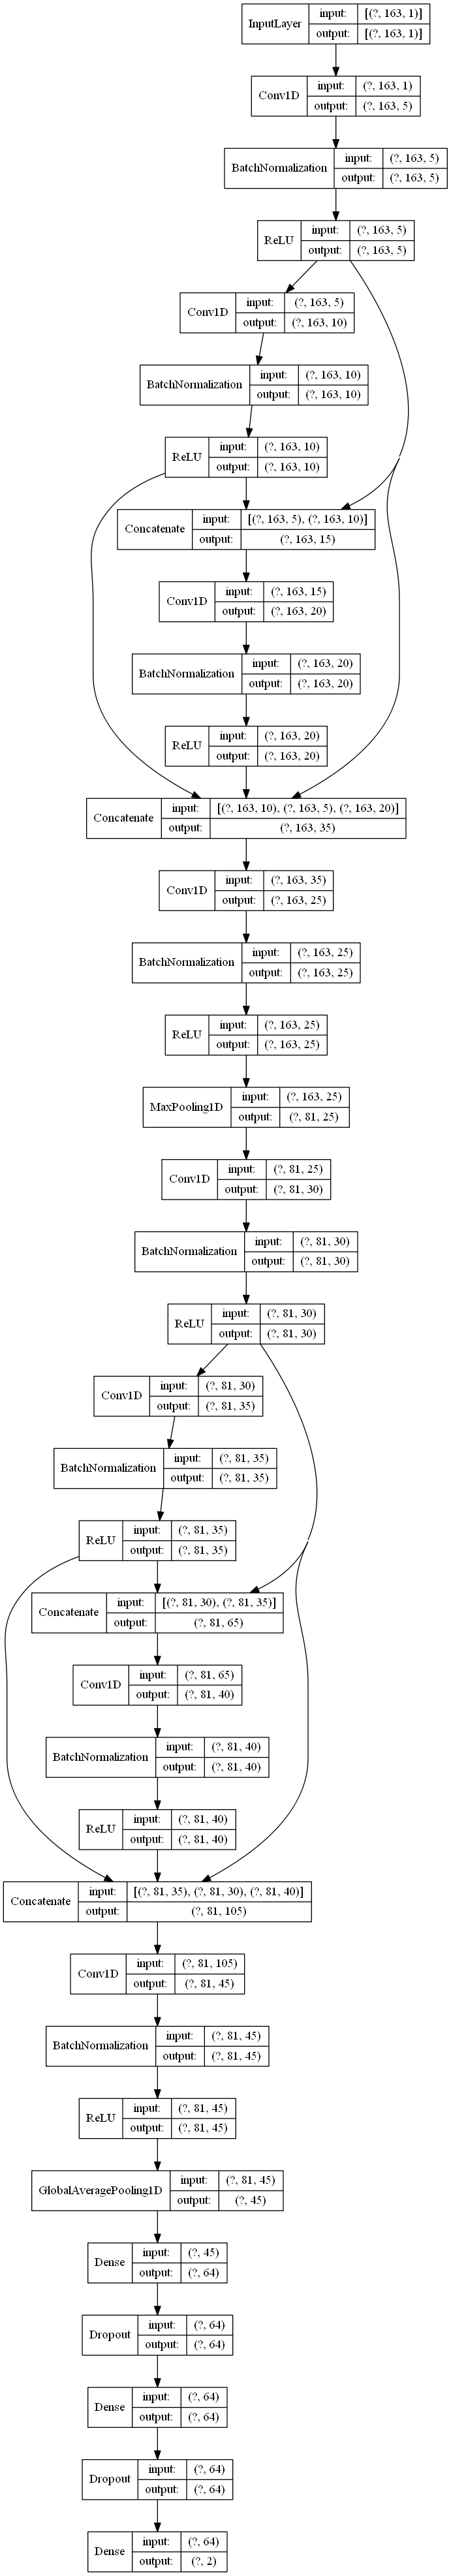

In [34]:
tf.keras.utils.plot_model(test_model_2, to_file='test_model_2_fdense.png', show_shapes=True, show_layer_names=False, rankdir='TB')

In [35]:
test = pd.DataFrame.from_dict(test_model_2.get_config()['layers'])
c = dict()
for i in test[test['class_name'] =='Conv1D'].index:
    c[i] = {'kernel':(test[test['class_name'] =='Conv1D']['config'][i]['kernel_size']) ,
    'filter' : (test[test['class_name'] =='Conv1D']['config'][i]['filters'])}
c

{1: {'kernel': (5,), 'filter': 5},
 4: {'kernel': (5,), 'filter': 10},
 8: {'kernel': (5,), 'filter': 20},
 12: {'kernel': (5,), 'filter': 25},
 16: {'kernel': (5,), 'filter': 30},
 19: {'kernel': (5,), 'filter': 35},
 23: {'kernel': (5,), 'filter': 40},
 27: {'kernel': (5,), 'filter': 45}}

## The 1st part of the hyperparameter gridsearch

In [36]:
gl_p = [False] #0
l2_batch = [ 0.0002] #1
n_ker = [5, 7] #2
n_fil = [ 5, 15] #3
d_hidden = [60, 100] #4
drop_out = [0.25] #5
reg_dense = [0.0002] #6
min_pool = [20] #7
# n_lay = [3, 6] #8  # это для CNN-сетки

In [37]:
param = itertools.product(gl_p, l2_batch, n_ker, n_fil, d_hidden, drop_out, reg_dense, min_pool)

In [38]:
inp_shape = X_2_2.shape[1]
inp_shape

128

In [39]:
training_generator = DataGenerator(train_for, x_col, y_col, batch_size=512, alpha = None, class_w = 0.1)

## F-DenseNet-6 (with pooling)
#### The 1st part of the hyperparameter gridsearch

In [40]:
VERBOSE = 2
BATCH_SIZE = 512
NB_EPOCH = 150
class_weighting = {0: 0.1, 1: 1}

result_all_8 = pd.DataFrame()
result_all_8['name_model'] = None
result_all_8['params'] = None
result_all_8['val_GINI'] = None
result_all_8['val_APS'] = None
result_all_8['test_GINI'] = None
result_all_8['test_APS'] = None
j = 0

for p in param:
    print(inp_shape, X_2_2.shape, p)

    
    ###############################
    #Вставить нужную функцию!!!!!!!!
    model_grid = fraud_dense_model_6_pool(l2_conv = None, reg = p[1] , reg_dense = p[6],
                                          n_features = inp_shape, n_pool = 2, n_kernel = p[2], n_filters = p[3],
                                          n_strides = 1, classes = 2, hidden = p[4], drop_out = 0.25,
                                          drop_out_conv = 0.001, drop_out_rate = 4, padding_pool = 'valid',
                                          gl_pool_max = False)

    model_grid.compile(loss='categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
                       metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    history_XX = model_grid.fit_generator(generator=training_generator,  # training_aug,
                                          # Y_test_2 = np_utils.to_categorical( y_val, 2)
                                          validation_data=(X_2_2, Y_test_2),
                                          epochs=NB_EPOCH, verbose=VERBOSE, class_weight=class_weighting,
                                          callbacks=[_time, EarlyStopping(monitor='val_loss', patience=20),
                                                     Metrics(valid_data=(X_2_2, Y_test_2))])

    res_model_ = pd.DataFrame(
        history_XX.history, columns=history_XX.history.keys())
    dd = str(200000 + datetime.now().month*100 +
             datetime.now().day) + '_' + str(datetime.now().hour)
    name_m = 'model_fDenseNet6_china_grid_' + str(p[1]) + '_' + str(
        p[2]) + '_' + str(p[3]) + '_' + str(p[4]) + '_' + str(p[6]) + '_' + str(dd)

    model_grid.save(name_m + '.h5')
    res_model_.to_csv(name_m + '.csv')

    predict_class_val = model_grid.predict(X_2_2)
    APS = metrics.average_precision_score(y_val, predict_class_val[:,1])
    GINI = 2*(metrics.roc_auc_score(y_val , predict_class_val[:,1])) - 1

    predict_class_test = model_grid.predict(X_3_2)
    APS_t = metrics.average_precision_score(y_test, predict_class_test[:,1])
    GINI_t = 2*(metrics.roc_auc_score(y_test, predict_class_test[:,1])) - 1

    result_all_8.at[j, 'name_model'] = name_m
    result_all_8.at[j, 'params'] = str(p)
    result_all_8.at[j, 'val_GINI'] = GINI
    result_all_8.at[j, 'val_APS'] = APS
    result_all_8.at[j, 'test_GINI'] = GINI_t
    result_all_8.at[j, 'test_APS'] = APS_t

    result_all_8.to_csv('model_fDenseNet6_china_grid_all.csv')
    j += 1
    print('==============================================')
    print(name_m, 'valid_for_train: ', GINI, APS, '| test: ', GINI_t, APS_t)
    print('==============================================')
    print('')
    


128 (99001, 128) (False, 0.0002, 5, 5, 60, 0.25, 0.0002, 20)
Instructions for updating:
Please use Model.fit, which supports generators.
train_begin | time:  30.04.2021 18:53:39
Epoch 1/150
epoch_end | time:  30.04.2021 18:57:56
 — val_aps:  0.453402 — val_a: 0.965801
1547/1547 - 264s - loss: 0.0357 - accuracy: 0.9513 - auc: 0.9858 - precision: 0.9513 - recall: 0.9513 - val_loss: 0.0949 - val_accuracy: 0.9727 - val_auc: 0.9935 - val_precision: 0.9727 - val_recall: 0.9727
Epoch 2/150
epoch_end | time:  30.04.2021 19:02:21
 — val_aps:  0.457482 — val_a: 0.967967
1547/1547 - 264s - loss: 0.0210 - accuracy: 0.9704 - auc: 0.9914 - precision: 0.9704 - recall: 0.9704 - val_loss: 0.2514 - val_accuracy: 0.9166 - val_auc: 0.9661 - val_precision: 0.9166 - val_recall: 0.9166
Epoch 3/150
epoch_end | time:  30.04.2021 19:06:54
 — val_aps:  0.448342 — val_a: 0.967242
1547/1547 - 277s - loss: 0.0186 - accuracy: 0.9734 - auc: 0.9927 - precision: 0.9734 - recall: 0.9734 - val_loss: 0.0525 - val_accuracy

Epoch 28/150
epoch_end | time:  30.04.2021 20:59:28
 — val_aps:  0.494762 — val_a: 0.969502
1547/1547 - 266s - loss: 0.0123 - accuracy: 0.9799 - auc: 0.9969 - precision: 0.9799 - recall: 0.9799 - val_loss: 0.0665 - val_accuracy: 0.9779 - val_auc: 0.9969 - val_precision: 0.9779 - val_recall: 0.9779
Epoch 29/150
epoch_end | time:  30.04.2021 21:03:54
 — val_aps:  0.469459 — val_a: 0.970644
1547/1547 - 268s - loss: 0.0123 - accuracy: 0.9795 - auc: 0.9969 - precision: 0.9795 - recall: 0.9795 - val_loss: 0.0921 - val_accuracy: 0.9643 - val_auc: 0.9938 - val_precision: 0.9643 - val_recall: 0.9643
Epoch 30/150
epoch_end | time:  30.04.2021 21:08:18
 — val_aps:  0.433562 — val_a: 0.968919
1547/1547 - 262s - loss: 0.0123 - accuracy: 0.9800 - auc: 0.9969 - precision: 0.9800 - recall: 0.9800 - val_loss: 0.1290 - val_accuracy: 0.9583 - val_auc: 0.9896 - val_precision: 0.9583 - val_recall: 0.9583
Epoch 31/150
epoch_end | time:  30.04.2021 21:12:41
 — val_aps:  0.449475 — val_a: 0.968198
1547/1547 -

Epoch 56/150
epoch_end | time:  30.04.2021 23:01:45
 — val_aps:  0.424694 — val_a: 0.967523
1547/1547 - 261s - loss: 0.0112 - accuracy: 0.9811 - auc: 0.9974 - precision: 0.9811 - recall: 0.9811 - val_loss: 0.0924 - val_accuracy: 0.9724 - val_auc: 0.9934 - val_precision: 0.9724 - val_recall: 0.9724
Epoch 57/150
epoch_end | time:  30.04.2021 23:06:06
 — val_aps:  0.472414 — val_a: 0.969371
1547/1547 - 260s - loss: 0.0112 - accuracy: 0.9813 - auc: 0.9975 - precision: 0.9813 - recall: 0.9813 - val_loss: 0.0670 - val_accuracy: 0.9794 - val_auc: 0.9960 - val_precision: 0.9794 - val_recall: 0.9794
Epoch 58/150
epoch_end | time:  30.04.2021 23:10:24
 — val_aps:  0.486112 — val_a: 0.966962
1547/1547 - 258s - loss: 0.0112 - accuracy: 0.9809 - auc: 0.9974 - precision: 0.9809 - recall: 0.9809 - val_loss: 0.0540 - val_accuracy: 0.9832 - val_auc: 0.9973 - val_precision: 0.9832 - val_recall: 0.9832
Epoch 59/150
epoch_end | time:  30.04.2021 23:14:44
 — val_aps:  0.490496 — val_a: 0.967328
1547/1547 -

Epoch 12/150
epoch_end | time:  01.05.2021 00:55:56
 — val_aps:  0.479817 — val_a: 0.971161
1547/1547 - 271s - loss: 0.0141 - accuracy: 0.9790 - auc_1: 0.9957 - precision_1: 0.9790 - recall_1: 0.9790 - val_loss: 0.1063 - val_accuracy: 0.9688 - val_auc_1: 0.9911 - val_precision_1: 0.9688 - val_recall_1: 0.9688
Epoch 13/150
epoch_end | time:  01.05.2021 01:00:21
 — val_aps:  0.478356 — val_a: 0.971501
1547/1547 - 264s - loss: 0.0139 - accuracy: 0.9792 - auc_1: 0.9958 - precision_1: 0.9792 - recall_1: 0.9792 - val_loss: 0.0521 - val_accuracy: 0.9843 - val_auc_1: 0.9975 - val_precision_1: 0.9843 - val_recall_1: 0.9843
Epoch 14/150
epoch_end | time:  01.05.2021 01:04:43
 — val_aps:  0.392690 — val_a: 0.968425
1547/1547 - 261s - loss: 0.0137 - accuracy: 0.9795 - auc_1: 0.9960 - precision_1: 0.9795 - recall_1: 0.9795 - val_loss: 0.1010 - val_accuracy: 0.9709 - val_auc_1: 0.9919 - val_precision_1: 0.9709 - val_recall_1: 0.9709
Epoch 15/150
epoch_end | time:  01.05.2021 01:09:05
 — val_aps:  0.

Epoch 39/150
epoch_end | time:  01.05.2021 02:54:45
 — val_aps:  0.510235 — val_a: 0.971380
1547/1547 - 263s - loss: 0.0117 - accuracy: 0.9810 - auc_1: 0.9972 - precision_1: 0.9810 - recall_1: 0.9810 - val_loss: 0.0703 - val_accuracy: 0.9789 - val_auc_1: 0.9955 - val_precision_1: 0.9789 - val_recall_1: 0.9789
Epoch 40/150
epoch_end | time:  01.05.2021 02:59:09
 — val_aps:  0.470281 — val_a: 0.969759
1547/1547 - 264s - loss: 0.0117 - accuracy: 0.9812 - auc_1: 0.9971 - precision_1: 0.9812 - recall_1: 0.9812 - val_loss: 0.1000 - val_accuracy: 0.9704 - val_auc_1: 0.9924 - val_precision_1: 0.9704 - val_recall_1: 0.9704
Epoch 41/150
epoch_end | time:  01.05.2021 03:03:33
 — val_aps:  0.470610 — val_a: 0.965425
1547/1547 - 264s - loss: 0.0117 - accuracy: 0.9815 - auc_1: 0.9971 - precision_1: 0.9815 - recall_1: 0.9815 - val_loss: 0.0549 - val_accuracy: 0.9833 - val_auc_1: 0.9971 - val_precision_1: 0.9833 - val_recall_1: 0.9833
Epoch 42/150
epoch_end | time:  01.05.2021 03:08:00
 — val_aps:  0.

Epoch 20/150
epoch_end | time:  01.05.2021 07:55:10
 — val_aps:  0.511269 — val_a: 0.971670
1547/1547 - 821s - loss: 0.0094 - accuracy: 0.9847 - auc_2: 0.9983 - precision_2: 0.9847 - recall_2: 0.9847 - val_loss: 0.0585 - val_accuracy: 0.9822 - val_auc_2: 0.9968 - val_precision_2: 0.9822 - val_recall_2: 0.9822
Epoch 21/150
epoch_end | time:  01.05.2021 08:08:55
 — val_aps:  0.497464 — val_a: 0.971924
1547/1547 - 825s - loss: 0.0093 - accuracy: 0.9852 - auc_2: 0.9983 - precision_2: 0.9852 - recall_2: 0.9852 - val_loss: 0.0617 - val_accuracy: 0.9826 - val_auc_2: 0.9962 - val_precision_2: 0.9826 - val_recall_2: 0.9826
Epoch 22/150
epoch_end | time:  01.05.2021 08:22:31
 — val_aps:  0.492465 — val_a: 0.969342
1547/1547 - 816s - loss: 0.0093 - accuracy: 0.9851 - auc_2: 0.9983 - precision_2: 0.9851 - recall_2: 0.9851 - val_loss: 0.0505 - val_accuracy: 0.9844 - val_auc_2: 0.9971 - val_precision_2: 0.9844 - val_recall_2: 0.9844
Epoch 23/150
epoch_end | time:  01.05.2021 08:36:11
 — val_aps:  0.

Epoch 47/150
epoch_end | time:  01.05.2021 14:19:32
 — val_aps:  0.499551 — val_a: 0.970226
1547/1547 - 799s - loss: 0.0077 - accuracy: 0.9876 - auc_2: 0.9988 - precision_2: 0.9876 - recall_2: 0.9876 - val_loss: 0.0763 - val_accuracy: 0.9762 - val_auc_2: 0.9954 - val_precision_2: 0.9762 - val_recall_2: 0.9762
Epoch 48/150
epoch_end | time:  01.05.2021 14:32:47
 — val_aps:  0.420175 — val_a: 0.962460
1547/1547 - 794s - loss: 0.0076 - accuracy: 0.9873 - auc_2: 0.9989 - precision_2: 0.9873 - recall_2: 0.9873 - val_loss: 0.0785 - val_accuracy: 0.9787 - val_auc_2: 0.9947 - val_precision_2: 0.9787 - val_recall_2: 0.9787
model_fDenseNet6_china_grid_0.0002_5_15_60_0.0002_200501_14 valid_for_train:  0.9249203857689556 0.4201747832891547 | test:  0.9206991354516989 0.3901262382893732

128 (99001, 128) (False, 0.0002, 5, 15, 100, 0.25, 0.0002, 20)
train_begin | time:  01.05.2021 14:33:33
Epoch 1/150
epoch_end | time:  01.05.2021 14:47:21
 — val_aps:  0.366673 — val_a: 0.964144
1547/1547 - 839s - 

Epoch 25/150
epoch_end | time:  01.05.2021 20:19:14
 — val_aps:  0.497890 — val_a: 0.967673
1547/1547 - 830s - loss: 0.0089 - accuracy: 0.9856 - auc_3: 0.9985 - precision_3: 0.9856 - recall_3: 0.9856 - val_loss: 0.0803 - val_accuracy: 0.9765 - val_auc_3: 0.9948 - val_precision_3: 0.9765 - val_recall_3: 0.9765
Epoch 26/150
epoch_end | time:  01.05.2021 20:33:05
 — val_aps:  0.494673 — val_a: 0.971673
1547/1547 - 829s - loss: 0.0089 - accuracy: 0.9855 - auc_3: 0.9985 - precision_3: 0.9855 - recall_3: 0.9855 - val_loss: 0.0529 - val_accuracy: 0.9851 - val_auc_3: 0.9968 - val_precision_3: 0.9851 - val_recall_3: 0.9851
Epoch 27/150
epoch_end | time:  01.05.2021 20:46:55
 — val_aps:  0.458557 — val_a: 0.966635
1547/1547 - 830s - loss: 0.0088 - accuracy: 0.9857 - auc_3: 0.9984 - precision_3: 0.9857 - recall_3: 0.9857 - val_loss: 0.0936 - val_accuracy: 0.9711 - val_auc_3: 0.9937 - val_precision_3: 0.9711 - val_recall_3: 0.9711
Epoch 28/150
epoch_end | time:  01.05.2021 21:00:52
 — val_aps:  0.

Epoch 20/150
epoch_end | time:  01.05.2021 23:26:34
 — val_aps:  0.468389 — val_a: 0.969099
1547/1547 - 302s - loss: 0.0122 - accuracy: 0.9799 - auc_4: 0.9969 - precision_4: 0.9799 - recall_4: 0.9799 - val_loss: 0.0647 - val_accuracy: 0.9783 - val_auc_4: 0.9966 - val_precision_4: 0.9783 - val_recall_4: 0.9783
Epoch 21/150
epoch_end | time:  01.05.2021 23:31:33
 — val_aps:  0.490479 — val_a: 0.970212
1547/1547 - 299s - loss: 0.0120 - accuracy: 0.9805 - auc_4: 0.9969 - precision_4: 0.9805 - recall_4: 0.9805 - val_loss: 0.0743 - val_accuracy: 0.9756 - val_auc_4: 0.9954 - val_precision_4: 0.9756 - val_recall_4: 0.9756
Epoch 22/150
epoch_end | time:  01.05.2021 23:36:33
 — val_aps:  0.498624 — val_a: 0.969459
1547/1547 - 299s - loss: 0.0118 - accuracy: 0.9808 - auc_4: 0.9971 - precision_4: 0.9808 - recall_4: 0.9808 - val_loss: 0.0435 - val_accuracy: 0.9856 - val_auc_4: 0.9982 - val_precision_4: 0.9856 - val_recall_4: 0.9856
Epoch 23/150
epoch_end | time:  01.05.2021 23:41:33
 — val_aps:  0.

Epoch 47/150
epoch_end | time:  02.05.2021 01:41:58
 — val_aps:  0.457959 — val_a: 0.965975
1547/1547 - 301s - loss: 0.0105 - accuracy: 0.9818 - auc_4: 0.9977 - precision_4: 0.9818 - recall_4: 0.9818 - val_loss: 0.0560 - val_accuracy: 0.9835 - val_auc_4: 0.9970 - val_precision_4: 0.9835 - val_recall_4: 0.9835
Epoch 48/150
epoch_end | time:  02.05.2021 01:46:58
 — val_aps:  0.498707 — val_a: 0.969675
1547/1547 - 300s - loss: 0.0106 - accuracy: 0.9816 - auc_4: 0.9976 - precision_4: 0.9816 - recall_4: 0.9816 - val_loss: 0.0547 - val_accuracy: 0.9825 - val_auc_4: 0.9977 - val_precision_4: 0.9825 - val_recall_4: 0.9825
Epoch 49/150
epoch_end | time:  02.05.2021 01:51:56
 — val_aps:  0.501966 — val_a: 0.967474
1547/1547 - 298s - loss: 0.0105 - accuracy: 0.9822 - auc_4: 0.9977 - precision_4: 0.9822 - recall_4: 0.9822 - val_loss: 0.0816 - val_accuracy: 0.9738 - val_auc_4: 0.9947 - val_precision_4: 0.9738 - val_recall_4: 0.9738
Epoch 50/150
epoch_end | time:  02.05.2021 01:56:52
 — val_aps:  0.

Epoch 17/150
epoch_end | time:  02.05.2021 03:53:08
 — val_aps:  0.475821 — val_a: 0.970331
1547/1547 - 306s - loss: 0.0123 - accuracy: 0.9808 - auc_5: 0.9968 - precision_5: 0.9808 - recall_5: 0.9808 - val_loss: 0.0979 - val_accuracy: 0.9717 - val_auc_5: 0.9915 - val_precision_5: 0.9717 - val_recall_5: 0.9717
Epoch 18/150
epoch_end | time:  02.05.2021 03:58:12
 — val_aps:  0.471957 — val_a: 0.970832
1547/1547 - 303s - loss: 0.0121 - accuracy: 0.9807 - auc_5: 0.9968 - precision_5: 0.9807 - recall_5: 0.9807 - val_loss: 0.0904 - val_accuracy: 0.9661 - val_auc_5: 0.9947 - val_precision_5: 0.9661 - val_recall_5: 0.9661
Epoch 19/150
epoch_end | time:  02.05.2021 04:03:18
 — val_aps:  0.481276 — val_a: 0.972047
1547/1547 - 306s - loss: 0.0120 - accuracy: 0.9808 - auc_5: 0.9969 - precision_5: 0.9808 - recall_5: 0.9808 - val_loss: 0.0523 - val_accuracy: 0.9826 - val_auc_5: 0.9975 - val_precision_5: 0.9826 - val_recall_5: 0.9826
Epoch 20/150
epoch_end | time:  02.05.2021 04:08:24
 — val_aps:  0.

Epoch 44/150
epoch_end | time:  02.05.2021 06:11:07
 — val_aps:  0.476960 — val_a: 0.966940
1547/1547 - 306s - loss: 0.0104 - accuracy: 0.9821 - auc_5: 0.9977 - precision_5: 0.9821 - recall_5: 0.9821 - val_loss: 0.0588 - val_accuracy: 0.9802 - val_auc_5: 0.9971 - val_precision_5: 0.9802 - val_recall_5: 0.9802
Epoch 45/150
epoch_end | time:  02.05.2021 06:16:14
 — val_aps:  0.496701 — val_a: 0.967544
1547/1547 - 306s - loss: 0.0102 - accuracy: 0.9825 - auc_5: 0.9978 - precision_5: 0.9825 - recall_5: 0.9825 - val_loss: 0.0503 - val_accuracy: 0.9854 - val_auc_5: 0.9974 - val_precision_5: 0.9854 - val_recall_5: 0.9854
Epoch 46/150
epoch_end | time:  02.05.2021 06:21:18
 — val_aps:  0.502471 — val_a: 0.968921
1547/1547 - 304s - loss: 0.0103 - accuracy: 0.9824 - auc_5: 0.9977 - precision_5: 0.9824 - recall_5: 0.9824 - val_loss: 0.0937 - val_accuracy: 0.9673 - val_auc_5: 0.9940 - val_precision_5: 0.9673 - val_recall_5: 0.9673
model_fDenseNet6_china_grid_0.0002_7_5_100_0.0002_200502_6 valid_fo

Epoch 24/150
epoch_end | time:  02.05.2021 12:28:41
 — val_aps:  0.526279 — val_a: 0.969105
1547/1547 - 895s - loss: 0.0087 - accuracy: 0.9859 - auc_6: 0.9984 - precision_6: 0.9859 - recall_6: 0.9859 - val_loss: 0.0448 - val_accuracy: 0.9889 - val_auc_6: 0.9971 - val_precision_6: 0.9889 - val_recall_6: 0.9889
Epoch 25/150
epoch_end | time:  02.05.2021 12:44:31
 — val_aps:  0.522238 — val_a: 0.967919
1547/1547 - 949s - loss: 0.0086 - accuracy: 0.9859 - auc_6: 0.9985 - precision_6: 0.9859 - recall_6: 0.9859 - val_loss: 0.0455 - val_accuracy: 0.9853 - val_auc_6: 0.9980 - val_precision_6: 0.9853 - val_recall_6: 0.9853
Epoch 26/150
epoch_end | time:  02.05.2021 12:59:16
 — val_aps:  0.411632 — val_a: 0.960027
1547/1547 - 885s - loss: 0.0084 - accuracy: 0.9861 - auc_6: 0.9985 - precision_6: 0.9861 - recall_6: 0.9861 - val_loss: 0.1032 - val_accuracy: 0.9686 - val_auc_6: 0.9927 - val_precision_6: 0.9686 - val_recall_6: 0.9686
Epoch 27/150
epoch_end | time:  02.05.2021 13:14:34
 — val_aps:  0.

Epoch 16/150
epoch_end | time:  02.05.2021 19:05:23
 — val_aps:  0.467917 — val_a: 0.971757
1547/1547 - 914s - loss: 0.0096 - accuracy: 0.9848 - auc_7: 0.9981 - precision_7: 0.9848 - recall_7: 0.9848 - val_loss: 0.0605 - val_accuracy: 0.9801 - val_auc_7: 0.9970 - val_precision_7: 0.9801 - val_recall_7: 0.9801
Epoch 17/150
epoch_end | time:  02.05.2021 19:20:23
 — val_aps:  0.486969 — val_a: 0.969099
1547/1547 - 899s - loss: 0.0094 - accuracy: 0.9852 - auc_7: 0.9981 - precision_7: 0.9852 - recall_7: 0.9852 - val_loss: 0.0378 - val_accuracy: 0.9895 - val_auc_7: 0.9979 - val_precision_7: 0.9895 - val_recall_7: 0.9895
Epoch 18/150
epoch_end | time:  02.05.2021 19:36:00
 — val_aps:  0.480344 — val_a: 0.972445
1547/1547 - 939s - loss: 0.0092 - accuracy: 0.9855 - auc_7: 0.9983 - precision_7: 0.9855 - recall_7: 0.9855 - val_loss: 0.1033 - val_accuracy: 0.9677 - val_auc_7: 0.9926 - val_precision_7: 0.9677 - val_recall_7: 0.9677
Epoch 19/150
epoch_end | time:  02.05.2021 19:51:02
 — val_aps:  0.

In [45]:
param = itertools.product(gl_p, l2_batch, n_ker, n_fil, d_hidden, drop_out, reg_dense, min_pool)

## F-DenseNet-8 (with pooling)

In [47]:
VERBOSE = 2
BATCH_SIZE = 512
NB_EPOCH = 150
class_weighting = {0: 0.1, 1: 1}

result_all_8 = pd.DataFrame()
result_all_8['name_model'] = None
result_all_8['params'] = None
result_all_8['val_GINI'] = None
result_all_8['val_APS'] = None
result_all_8['test_GINI'] = None
result_all_8['test_APS'] = None
j = 0

for p in param:
    print(inp_shape, X_2_2.shape, p)

    
    ###############################
    #Вставить нужную функцию!!!!!!!!
    model_grid = fraud_dense_model_8_pool(l2_conv = None, reg = p[1] , reg_dense = p[6],
                                          n_features = inp_shape, n_pool = 2, n_kernel = p[2], n_filters = p[3],
                                          n_strides = 1, classes = 2, hidden = p[4], drop_out = 0.25,
                                          drop_out_conv = 0.001, drop_out_rate = 4, padding_pool = 'valid',
                                          gl_pool_max = False, min_pool = 20, str_pool = None)
   
    
    
    model_grid.compile(loss='categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
                       metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    history_XX = model_grid.fit_generator(generator=training_generator,  # training_aug,
                                          # Y_test_2 = np_utils.to_categorical( y_val, 2)
                                          validation_data=(X_2_2, Y_test_2),
                                          epochs=NB_EPOCH, verbose=VERBOSE, class_weight=class_weighting,
                                          callbacks=[_time, EarlyStopping(monitor='val_loss', patience=20),
                                                     Metrics(valid_data=(X_2_2, Y_test_2))])

    res_model_ = pd.DataFrame(
        history_XX.history, columns=history_XX.history.keys())
    dd = str(200000 + datetime.now().month*100 +
             datetime.now().day) + '_' + str(datetime.now().hour)
    name_m = 'model_fDenseNet8_china_grid_' + str(p[1]) + '_' + str(
        p[2]) + '_' + str(p[3]) + '_' + str(p[4]) + '_' + str(p[6]) + '_' + str(dd)

    model_grid.save(name_m + '.h5')
    res_model_.to_csv(name_m + '.csv')

    predict_class_val = model_grid.predict(X_2_2)
    APS = metrics.average_precision_score(y_val, predict_class_val[:,1])
    GINI = 2*(metrics.roc_auc_score(y_val , predict_class_val[:,1])) - 1

    predict_class_test = model_grid.predict(X_3_2)
    APS_t = metrics.average_precision_score(y_test, predict_class_test[:,1])
    GINI_t = 2*(metrics.roc_auc_score(y_test, predict_class_test[:,1])) - 1

    result_all_8.at[j, 'name_model'] = name_m
    result_all_8.at[j, 'params'] = str(p)
    result_all_8.at[j, 'val_GINI'] = GINI
    result_all_8.at[j, 'val_APS'] = APS
    result_all_8.at[j, 'test_GINI'] = GINI_t
    result_all_8.at[j, 'test_APS'] = APS_t

    result_all_8.to_csv('model_fDenseNet8_china_grid_all.csv')
    j += 1
    
    print('==============================================')
    print(name_m, 'valid_for_train: ', GINI, APS, '| test: ', GINI_t, APS_t)
    print('==============================================')
    print('')

128 (99001, 128) (False, 0.0002, 5, 5, 60, 0.25, 0.0002, 20)
train_begin | time:  04.05.2021 11:42:10
Epoch 1/150
epoch_end | time:  04.05.2021 11:49:44
 — val_aps:  0.337941 — val_a: 0.958329
1547/1547 - 466s - loss: 0.0385 - accuracy: 0.9510 - auc_8: 0.9864 - precision_8: 0.9510 - recall_8: 0.9510 - val_loss: 0.1696 - val_accuracy: 0.9510 - val_auc_8: 0.9798 - val_precision_8: 0.9510 - val_recall_8: 0.9510
Epoch 2/150
epoch_end | time:  04.05.2021 11:57:42
 — val_aps:  0.399421 — val_a: 0.965316
1547/1547 - 478s - loss: 0.0202 - accuracy: 0.9720 - auc_8: 0.9920 - precision_8: 0.9720 - recall_8: 0.9720 - val_loss: 0.0526 - val_accuracy: 0.9846 - val_auc_8: 0.9978 - val_precision_8: 0.9846 - val_recall_8: 0.9846
Epoch 3/150
epoch_end | time:  04.05.2021 12:06:32
 — val_aps:  0.451247 — val_a: 0.970130
1547/1547 - 533s - loss: 0.0175 - accuracy: 0.9759 - auc_8: 0.9936 - precision_8: 0.9759 - recall_8: 0.9759 - val_loss: 0.0982 - val_accuracy: 0.9714 - val_auc_8: 0.9925 - val_precision_8

 — val_aps:  0.477562 — val_a: 0.972036
1547/1547 - 774s - loss: 0.0114 - accuracy: 0.9814 - auc_8: 0.9974 - precision_8: 0.9814 - recall_8: 0.9814 - val_loss: 0.0591 - val_accuracy: 0.9836 - val_auc_8: 0.9964 - val_precision_8: 0.9836 - val_recall_8: 0.9836
Epoch 28/150
epoch_end | time:  04.05.2021 16:09:01
 — val_aps:  0.481781 — val_a: 0.966888
1547/1547 - 771s - loss: 0.0113 - accuracy: 0.9820 - auc_8: 0.9974 - precision_8: 0.9820 - recall_8: 0.9820 - val_loss: 0.0561 - val_accuracy: 0.9810 - val_auc_8: 0.9972 - val_precision_8: 0.9810 - val_recall_8: 0.9810
Epoch 29/150
epoch_end | time:  04.05.2021 16:22:40
 — val_aps:  0.268860 — val_a: 0.946373
1547/1547 - 836s - loss: 0.0113 - accuracy: 0.9816 - auc_8: 0.9974 - precision_8: 0.9816 - recall_8: 0.9816 - val_loss: 0.4707 - val_accuracy: 0.8422 - val_auc_8: 0.9223 - val_precision_8: 0.8422 - val_recall_8: 0.8422
Epoch 30/150
epoch_end | time:  04.05.2021 16:35:51
 — val_aps:  0.508175 — val_a: 0.969127
1547/1547 - 777s - loss: 0.

Epoch 7/150
epoch_end | time:  04.05.2021 22:25:12
 — val_aps:  0.426578 — val_a: 0.965864
1547/1547 - 901s - loss: 0.0151 - accuracy: 0.9787 - auc_9: 0.9951 - precision_9: 0.9787 - recall_9: 0.9787 - val_loss: 0.0523 - val_accuracy: 0.9858 - val_auc_9: 0.9982 - val_precision_9: 0.9858 - val_recall_9: 0.9858
Epoch 8/150
epoch_end | time:  04.05.2021 22:40:21
 — val_aps:  0.472055 — val_a: 0.971791
1547/1547 - 905s - loss: 0.0148 - accuracy: 0.9789 - auc_9: 0.9953 - precision_9: 0.9789 - recall_9: 0.9789 - val_loss: 0.0570 - val_accuracy: 0.9825 - val_auc_9: 0.9978 - val_precision_9: 0.9825 - val_recall_9: 0.9825
Epoch 9/150
epoch_end | time:  04.05.2021 22:55:07
 — val_aps:  0.451442 — val_a: 0.972516
1547/1547 - 892s - loss: 0.0145 - accuracy: 0.9791 - auc_9: 0.9955 - precision_9: 0.9791 - recall_9: 0.9791 - val_loss: 0.1316 - val_accuracy: 0.9613 - val_auc_9: 0.9882 - val_precision_9: 0.9613 - val_recall_9: 0.9613
Epoch 10/150
epoch_end | time:  04.05.2021 23:10:14
 — val_aps:  0.471

Epoch 36/150
epoch_end | time:  06.05.2021 19:24:39
 — val_aps:  0.501649 — val_a: 0.970408
1547/1547 - 2281s - loss: 0.0082 - accuracy: 0.9869 - auc_10: 0.9987 - precision_10: 0.9869 - recall_10: 0.9869 - val_loss: 0.0963 - val_accuracy: 0.9566 - val_auc_10: 0.9941 - val_precision_10: 0.9566 - val_recall_10: 0.9566
Epoch 37/150
epoch_end | time:  06.05.2021 20:02:43
 — val_aps:  0.487197 — val_a: 0.968387
1547/1547 - 2283s - loss: 0.0081 - accuracy: 0.9870 - auc_10: 0.9987 - precision_10: 0.9870 - recall_10: 0.9870 - val_loss: 0.0464 - val_accuracy: 0.9886 - val_auc_10: 0.9968 - val_precision_10: 0.9886 - val_recall_10: 0.9886
Epoch 38/150
epoch_end | time:  06.05.2021 20:38:12
 — val_aps:  0.463066 — val_a: 0.966486
1547/1547 - 2124s - loss: 0.0080 - accuracy: 0.9872 - auc_10: 0.9988 - precision_10: 0.9872 - recall_10: 0.9872 - val_loss: 0.1709 - val_accuracy: 0.9342 - val_auc_10: 0.9843 - val_precision_10: 0.9342 - val_recall_10: 0.9342
model_fDenseNet8_china_grid_0.0002_5_15_60_0.0

Epoch 23/150
epoch_end | time:  07.05.2021 09:58:45
 — val_aps:  0.457864 — val_a: 0.967320
1547/1547 - 2074s - loss: 0.0091 - accuracy: 0.9857 - auc_11: 0.9984 - precision_11: 0.9857 - recall_11: 0.9857 - val_loss: 0.0682 - val_accuracy: 0.9797 - val_auc_11: 0.9958 - val_precision_11: 0.9797 - val_recall_11: 0.9797
Epoch 24/150
epoch_end | time:  07.05.2021 10:36:18
 — val_aps:  0.489419 — val_a: 0.968045
1547/1547 - 2256s - loss: 0.0090 - accuracy: 0.9859 - auc_11: 0.9984 - precision_11: 0.9859 - recall_11: 0.9859 - val_loss: 0.0507 - val_accuracy: 0.9819 - val_auc_11: 0.9977 - val_precision_11: 0.9819 - val_recall_11: 0.9819
Epoch 25/150
epoch_end | time:  07.05.2021 11:13:29
 — val_aps:  0.424780 — val_a: 0.969651
1547/1547 - 2228s - loss: 0.0089 - accuracy: 0.9859 - auc_11: 0.9985 - precision_11: 0.9859 - recall_11: 0.9859 - val_loss: 0.0758 - val_accuracy: 0.9738 - val_auc_11: 0.9957 - val_precision_11: 0.9738 - val_recall_11: 0.9738
Epoch 26/150
epoch_end | time:  07.05.2021 11:

KeyboardInterrupt: 

In [46]:
print(inp_shape, X_2_2.shape, p)

128 (99001, 128) (False, 0.0002, 7, 15, 100, 0.25, 0.0002, 20)
